# Credit Card Fraud Detection

## Импортируем необходимые библиотеки

In [1]:
import numpy as np 
import pandas as pd #
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost as xgb

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

## Изучим данные

Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года держателями карт из Европы.
Этот набор данных представляет транзакции, которые произошли за два дня, где у нас есть 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован. На положительный класс (мошенничество) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. Из соображений конфиденциальности исходные данные и дополнительная справочная информация о данных не предоставляется. Признаки V1, V2, … V28 являются основными компонентами, полученными с помощью PCA. Единственные признаки, которые не были преобразованы с помощью PCA, — это «Время» и «Количество». Признак «Время» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. «Сумма» — это сумма транзакции. «Класс» — это переменная, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

In [161]:
data = pd.read_csv('creditcard.csv')

In [3]:
# В датасете 284807 строк и 31 признак
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# В датасете нет пропущенных значений
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
# Соотношение классов в датасете крайне несбалансировано. Необходимо будет это учитывать при дальнейшей работе с данными.
                                        
print(f" {round((data['Class'].value_counts()[0])/len(data['Class'])*100, 2)}% обычных операций")
print(f" {round((data['Class'].value_counts()[1])/len(data['Class'])*100, 2)}% мошеннических операций")

 99.83% обычных операций
 0.17% мошеннических операций


Text(0.5, 1.0, 'Распределение классов \n (0: Обычные операции || 1: Мошеннические операции)')

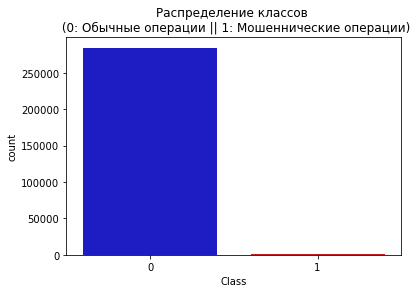

In [3]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=data, palette=colors)
plt.title('Распределение классов \n (0: Обычные операции || 1: Мошеннические операции)', fontsize=12)

(0.0, 172792.0)

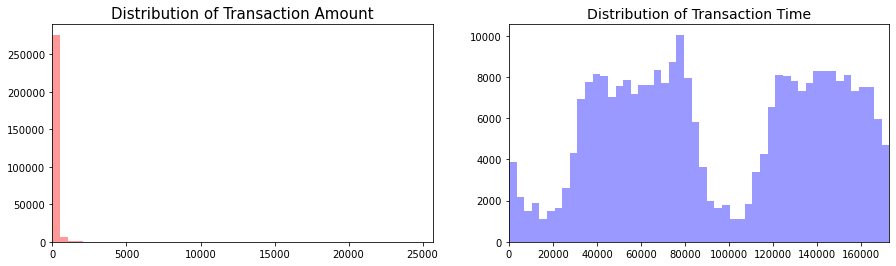

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

# distplot одновременно показывает гистограмму и график плотности распределения. 
# kde=False - оставляем только гистограмму

sns.distplot(amount_val, ax=ax[0], color='r', kde=False)
ax[0].set_title('Distribution of Transaction Amount', fontsize=15)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b', kde=False)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

## Масштабирование признаков 

Так как большая часть наших данных уже масштабирована, мы должны масштабировать признаки 'Time' и 'Amount'. 

Для этого используем алгоритм Robust Scaler, так как он устойчив к выбросам. Статистика центрирования и масштабирования RobustScaler основана на медиане и процентилях поэтому не зависит от небольшого числа предельных выбросов.

In [5]:
rs = RobustScaler()
data['scaled_amount'] = rs.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rs.fit_transform(data['Time'].values.reshape(-1,1))
data.drop(['Time', 'Amount'], axis=1, inplace=True)

In [11]:
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.296653,1.034951
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,0.038986,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,0.641096,1.034975
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.167680,1.034975


In [6]:
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']
data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(0, 'scaled_time', scaled_time)
data

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.034951,-0.296653,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,1.034963,0.038986,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,1.034975,0.641096,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,1.034975,-0.167680,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


Таким образом, признаки Time и Amount теперь масштабированы.

#### Этот набор данных сильно несбалансирован (большинство транзакций не мошеннические). При таком соотношении классов, модели проще всего будет отнести большинство случаев к немошенническим, получив при этом высокую точноть. Но в данном случае высокая точность не будет объективной. Чтобы решить проблему несбалансированного набора данных, мы можем использовать специальные методы, которые позволят получить нам набор данных с примерно одинакоовым соотношением позитивных и негативных классов. Существует метод под названием SMOTE (Synthetic Minority Oversampling Technique, который мы собираемся использовать, чтобы сделать наш набор данных сбалансированным. Он создает синтетические точки из класса меньшинства 

Обучать модели на исходных данных, oversemplig-данных и undersamplimg-данных и сравним результаты.



## Сэмплинг

Как было описано выше, дисбаланс классов может очень сильно влиять на точность результатов. 
Наша цель добиться равного рапределения классов. 

Этого можно добиться двумя путями:
- oversampling: удаление некоторого количества сэплов мажоритарного класса для достижения необходимого соотношения классов.
- undersampling: искусственное учеличение сэмплов миноритарного класса

In [7]:
# Сначала разделим имеющиеся данные на тренирововчные и тестовые
from sklearn.model_selection import train_test_split
x = np.array(data.iloc[:, data.columns != 'Class'])
y = np.array(data.iloc[:, data.columns == 'Class'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print(f'Обычные транзакции: {sum(y_train == 0)}')
print(f'Мошеннические транзакции: {sum(y_train == 1)}')

Обычные транзакции: [227454]
Мошеннические транзакции: [391]


### - NearMiss (Oversampling)
Основная идея «умного недосэмплирования» – брать из большого класса только объекты важные для решения рассматриваемой задачи. Стратегия метода NearMiss-1 – из большего класса выбираем объекты, у которых среднее расстояний до N ближайших малого класса наименьшее, т.е. из граничной зоны (первая картинка рис. 4.1). Стратегия метода NearMiss-2 – из большего класса выбираем объекты, у которых среднее расстояний до N дальних малого класса наименьшее (вторая картинка рис. 4.1). Стратегия метода Tomek links – удалить объекты большого класса, образующие связи Томека (объекты двух разных классов образуют связь Томека, если нет объекта, который ближе к одному из них при этом являясь объектом другого класса)

In [8]:
from imblearn.under_sampling import NearMiss
model_near_miss = NearMiss()
x_train_nearmiss, y_train_nearmiss = model_near_miss.fit_resample(x_train, y_train.ravel())

print(f'Обычные транзакции: {sum(y_train_nearmiss == 0)}')
print(f'Мошеннические транзакции: {sum(y_train_nearmiss == 1)}')

Обычные транзакции: 391
Мошеннические транзакции: 391


### - SMOTE (Undersampling)
В методе SMOTE для точки малого класса выбирается один из k ближайших соседей и на отрезке между ними случайно выбирается новый объект.

In [9]:
model_smote = SMOTE(random_state=2)
x_train_smote, y_train_smote = model_smote.fit_resample(x_train, y_train.ravel())

print(f'Обычные транзакции: {sum(y_train_smote == 0)}')
print(f'Мошеннические транзакции: {sum(y_train_smote == 1)}')

Обычные транзакции: 227454
Мошеннические транзакции: 227454


Таким образом мы получили три пары тренировочных датасетов: 
- x_train, y_train (класс - 227454 объекта, класс 1 - 391 объект)
- x_train_nearmiss, y_train_nearmiss (класс - 391 объект, класс 1 - 391 объект)
- x_train_smote, y_train_smote (класс - 227454 объекта, класс 1 - 227454 объекта)


#### Важно заметить: мы получаем новые тренировочные датасеты при реализации методов NearMiss и SMOTE, но тестировать модели, обученные на этих данных, мы будем на исходном тестовом наборе, а не на тестовом наборе, созданном любым из этих методов. Так как основная цель - это подать такие даные для обучения, чтобы нашим моделям было "удобно" обнаруживать закономерности. Но качетво результатов целесообразно оценивать на исходном тестовом наборе.

Для наглядности обучать модели будем на всех трех тестовых выборках и сравнивать результаты.

## Logistic Regression

In [33]:
#Несбалансированные тренирововчные датасеты 

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.88      0.63      0.74       101

                accuracy                           1.00     56962
               macro avg       0.94      0.82      0.87     56962
            weighted avg       1.00      1.00      1.00     56962



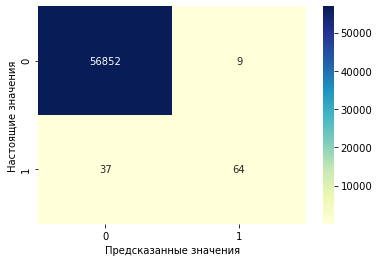

In [34]:
cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred, target_names=labels))
# display(classification_report(y_test, y_pred, target_names=labels))

Text(0.5, 1.0, 'Precision Recall Curve')

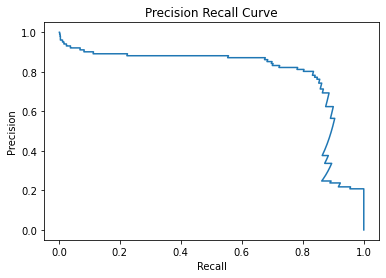

In [35]:
y_pred_prob = logreg.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

### ________________________________ Logistic Regression + NearMiss

In [62]:
logreg_nearmiss = LogisticRegression()

logreg_nearmiss.fit(x_train_nearmiss, y_train_nearmiss)
y_pred_nearmiss = logreg_nearmiss.predict(x_test)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.64      0.78     56861
Мошеннические транзакции       0.00      0.95      0.01       101

                accuracy                           0.64     56962
               macro avg       0.50      0.80      0.40     56962
            weighted avg       1.00      0.64      0.78     56962



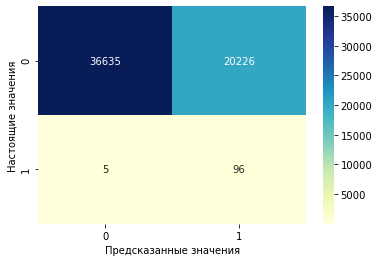

In [63]:
cnf_matrix_nearmiss = confusion_matrix(y_test, y_pred_nearmiss)

sns.heatmap(pd.DataFrame(cnf_matrix_nearmiss), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_nearmiss, target_names=labels))

###  _______________Logistic Regression + SMOTE

In [10]:
logreg_smote = LogisticRegression()
logreg_smote.fit(x_train_smote, y_train_smote)
y_pred_logreg_smote = logreg_smote.predict(x_test)

In [63]:
joblib.dump(logreg_smote, "logreg_smote.pkl")

['logreg_smote.pkl']

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.98      0.99     56861
Мошеннические транзакции       0.06      0.94      0.12       101

                accuracy                           0.98     56962
               macro avg       0.53      0.96      0.55     56962
            weighted avg       1.00      0.98      0.99     56962



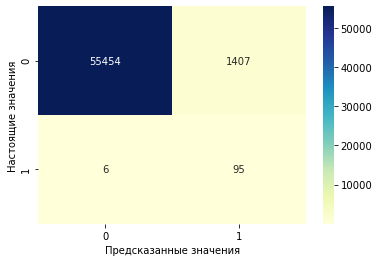

In [11]:
cnf_matrix_logreg_smote = confusion_matrix(y_test, y_pred_logreg_smote)

sns.heatmap(pd.DataFrame(cnf_matrix_logreg_smote), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения') 

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_logreg_smote, target_names=labels))

Text(0.5, 1.0, 'Precision Recall Curve')

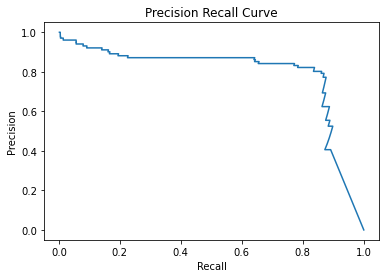

In [37]:
y_pred_prob_logreg_smote = logreg_smote.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_logreg_smote)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

Видим, что модель отработала не очень хорошо. Да, ошибочно мошенническими были признаны всего 9 транзакция из 56861 (0,0016%). Но для нас важнее не пропускать мошеннические тразакции, а здесь все плохо: из 101 мошеннической транзакции 37 были незамечены (36%)

### KNN 

Метод k-ближайших соседей используется для решения задачи классификации. Он относит объекты к классу, которому принадлежит большинство из k его ближайших соседей в многомерном пространстве признаков. Это один из простейших алгоритмов обучения классификационных моделей, но он устойчив к дисбалансу классов.

In [67]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(x_train, y_train)
y_pred_knn = model_knn.predict(x_test)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.93      0.80      0.86       101

                accuracy                           1.00     56962
               macro avg       0.97      0.90      0.93     56962
            weighted avg       1.00      1.00      1.00     56962



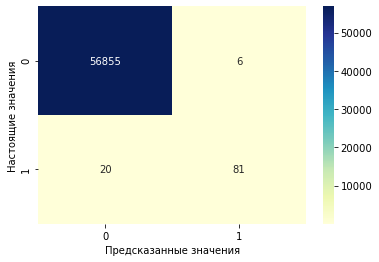

In [68]:
cnf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

sns.heatmap(pd.DataFrame(cnf_matrix_knn), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_knn, target_names=labels))

### ________KNN + NearMiss

In [88]:
model_knn_nearmiss = KNeighborsClassifier(n_neighbors=5)
model_knn_nearmiss.fit(x_train_nearmiss, y_train_nearmiss)
y_pred_knn_nearmiss = model_knn_nearmiss.predict(x_test)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.77      0.87     56861
Мошеннические транзакции       0.01      0.94      0.01       101

                accuracy                           0.77     56962
               macro avg       0.50      0.86      0.44     56962
            weighted avg       1.00      0.77      0.87     56962



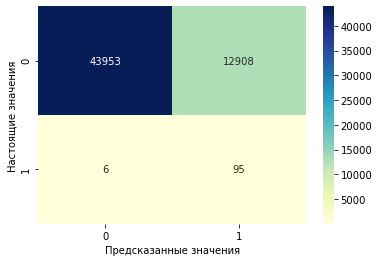

In [91]:
cnf_matrix_knn_nearmiss = confusion_matrix(y_test, y_pred_knn_nearmiss)

sns.heatmap(pd.DataFrame(cnf_matrix_knn_nearmiss), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_knn_nearmiss, target_names=labels))

### __________________________    KNN + SMOTE

In [13]:
model_knn_smote = KNeighborsClassifier(n_neighbors=5)
model_knn_smote.fit(x_train_smote, y_train_smote)
y_pred_knn_smote = model_knn_smote.predict(x_test)

In [64]:
joblib.dump(model_knn_smote, "model_knn_smote.pkl")

['model_knn_smote.pkl']

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.52      0.89      0.66       101

                accuracy                           1.00     56962
               macro avg       0.76      0.94      0.83     56962
            weighted avg       1.00      1.00      1.00     56962



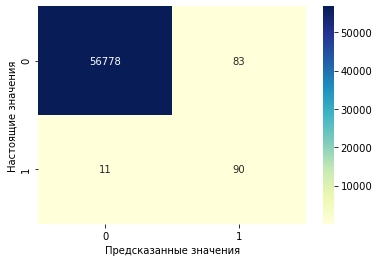

In [14]:
cnf_matrix_knn_smote = confusion_matrix(y_test, y_pred_knn_smote)

sns.heatmap(pd.DataFrame(cnf_matrix_knn_smote), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_knn_smote, target_names=labels))

Text(0.5, 1.0, 'Precision Recall Curve')

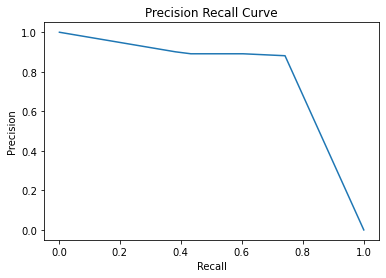

In [15]:
y_pred_prob_knn_smote = model_knn_smote.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_knn_smote)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

## SVM

Метод опорных векторов (англ. SVM, support vector machine) — набор схожих алгоритмов обучения с учителем, использующихся для задач классификации и регрессионного анализа.

Основная идея метода — перевод исходных векторов в пространство более высокой размерности и поиск разделяющей гиперплоскости с наибольшим зазором в этом пространстве. Две параллельных гиперплоскости строятся по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, создающая наибольшее расстояние до двух параллельных гиперплоскостей. Алгоритм основан на допущении, что чем больше разница или расстояние между этими параллельными гиперплоскостями, тем меньше будет средняя ошибка классификатора.

In [95]:
#Несбалансированные тренирововчные датасеты 

model_svm = svm.SVC(kernel='poly', degree=2)
model_svm.fit(x_train, y_train)
y_pred_svm = model_svm.predict(x_test)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.92      0.72      0.81       101

                accuracy                           1.00     56962
               macro avg       0.96      0.86      0.91     56962
            weighted avg       1.00      1.00      1.00     56962



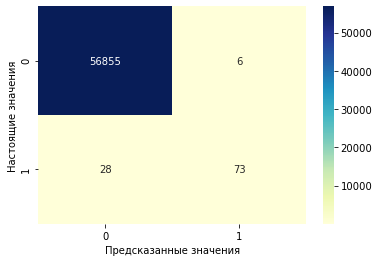

In [96]:
cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(pd.DataFrame(cnf_matrix_svm), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_svm, target_names=labels))

### _________________SVM + NearMiss

In [97]:
model_svm_nearmiss = svm.SVC(kernel='poly', degree=2)
model_svm_nearmiss.fit(x_train_nearmiss, y_train_nearmiss)
y_pred_svm_nearmiss = model_svm_nearmiss.predict(x_test)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.99      0.99     56861
Мошеннические транзакции       0.11      0.84      0.19       101

                accuracy                           0.99     56962
               macro avg       0.55      0.91      0.59     56962
            weighted avg       1.00      0.99      0.99     56962



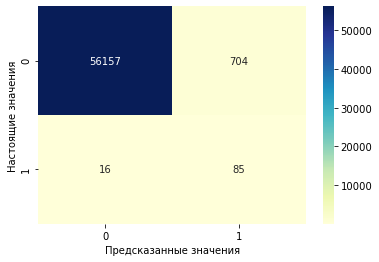

In [98]:
cnf_matrix_svm_nearmiss = confusion_matrix(y_test, y_pred_svm_nearmiss)

sns.heatmap(pd.DataFrame(cnf_matrix_svm_nearmiss), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_svm_nearmiss, target_names=labels))

### ________________SVM + SMOTE

In [16]:
model_svm_smote = svm.SVC(kernel='poly', degree=2, probability = True)
model_svm_smote.fit(x_train_smote, y_train_smote)
y_pred_svm_smote = model_svm_smote.predict(x_test)

In [65]:
joblib.dump(model_svm_smote, "model_svm_smote.pkl")

['model_svm_smote.pkl']

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.99      1.00     56861
Мошеннические транзакции       0.17      0.90      0.29       101

                accuracy                           0.99     56962
               macro avg       0.59      0.95      0.64     56962
            weighted avg       1.00      0.99      0.99     56962



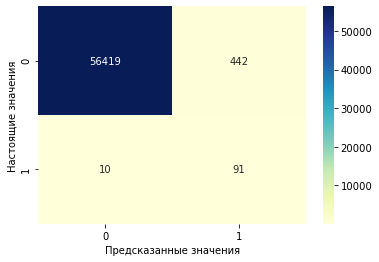

In [17]:
cnf_matrix_svm_smote = confusion_matrix(y_test, y_pred_svm_smote)

sns.heatmap(pd.DataFrame(cnf_matrix_svm_smote), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_svm_smote, target_names=labels))

Text(0.5, 1.0, 'Precision Recall Curve')

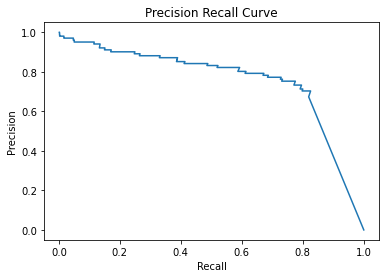

In [18]:
y_pred_prob_svm_smote = model_svm_smote.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_svm_smote)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

Мы получили высокий показатель полноты (recall) , что означает, что наша модель способна обнаружить наибольшее количество мошеннических транзакций, в то время как точность (precision) очень низкая. Это означает, что модель классифицирует множество обычных транзакций как мошенничество. Клиенты банка будут недовольны, если их будут часто беспокоить по подозрению в мошеннических транзакциях. Так что в этом случае также важно иметь высокую точность, которую мы попытаемся достичь с помощью Random Forest.

## Random Forest Classifier 

Это множество решающих деревьев. В задаче регрессии их ответы усредняются, в задаче классификации принимается решение голосованием по большинству. Все деревья строятся независимо по следующей схеме:

- Выбирается подвыборка обучающей выборки размера samplesize (м.б. с возвращением) – по ней строится дерево (для каждого дерева — своя подвыборка).
- Для построения каждого расщепления в дереве просматриваем max_features случайных признаков (для каждого нового расщепления — свои случайные признаки).
- Выбираем наилучшие признак и расщепление по нему (по заранее заданному критерию). Дерево строится, как правило, до исчерпания выборки (пока в листьях не останутся представители только одного класса), но в современных реализациях есть параметры, которые ограничивают высоту дерева, число объектов в листьях и число объектов в подвыборке, при котором проводится расщепление.

In [104]:
#Несбалансированные тренирововчные датасеты 

rand_f = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=1,
           max_features='auto', max_leaf_nodes=None,
           oob_score=True, n_jobs=-1, random_state=1)
rand_f.fit(x_train, y_train)
y_pred_randf = rand_f.predict(x_test)


                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.91      0.78      0.84       101

                accuracy                           1.00     56962
               macro avg       0.95      0.89      0.92     56962
            weighted avg       1.00      1.00      1.00     56962



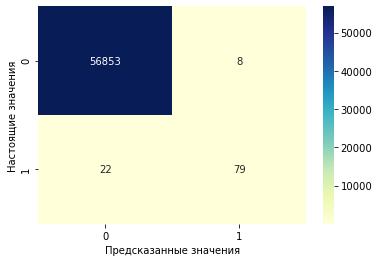

In [105]:
cnf_matrix_rand_f = confusion_matrix(y_test, y_pred_randf)

sns.heatmap(pd.DataFrame(cnf_matrix_rand_f), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_randf, target_names=labels))

### __________________Random Forest Classifier + NearMiss

In [109]:
model_rand_f_nearmiss = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=1,
           max_features='auto', max_leaf_nodes=None,
           oob_score=True, n_jobs=-1, random_state=1)

model_rand_f_nearmiss.fit(x_train_nearmiss, y_train_nearmiss)
y_pred_rand_f_nearmiss = model_rand_f_nearmiss.predict(x_test)


                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.18      0.31     56861
Мошеннические транзакции       0.00      0.98      0.00       101

                accuracy                           0.18     56962
               macro avg       0.50      0.58      0.16     56962
            weighted avg       1.00      0.18      0.31     56962



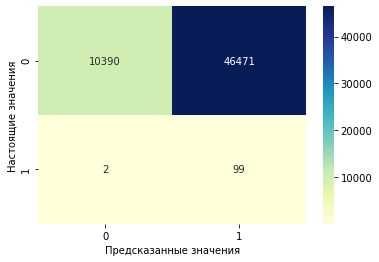

In [115]:
cnf_matrix_rand_f_nearmiss = confusion_matrix(y_test, y_pred_rand_f_nearmiss)

sns.heatmap(pd.DataFrame(cnf_matrix_rand_f_nearmiss), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_rand_f_nearmiss, target_names=labels))

### __________________Random Forest Classifier + SMOTE

In [19]:
model_rand_f_smote = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=1,
           max_features='auto', max_leaf_nodes=None,
           oob_score=True, n_jobs=-1, random_state=1)

model_rand_f_smote.fit(x_train_smote, y_train_smote)
y_pred_rand_f_smote = model_rand_f_smote.predict(x_test)


In [66]:
joblib.dump(model_rand_f_smote, "model_rand_f_smote.pkl")

['model_rand_f_smote.pkl']

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.88      0.83      0.86       101

                accuracy                           1.00     56962
               macro avg       0.94      0.92      0.93     56962
            weighted avg       1.00      1.00      1.00     56962



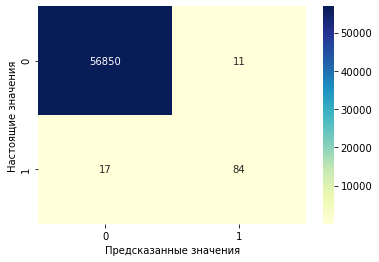

In [20]:
cnf_matrix_rand_f_smote = confusion_matrix(y_test, y_pred_rand_f_smote)

sns.heatmap(pd.DataFrame(cnf_matrix_rand_f_smote), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_rand_f_smote, target_names=labels))

Text(0.5, 1.0, 'Precision Recall Curve')

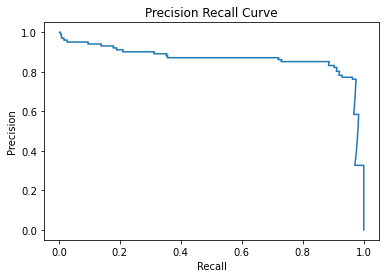

In [21]:
y_pred_prob_rand_f_smote = model_rand_f_smote.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_rand_f_smote)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

Random Forest Classifier показал результаты гораздо лучше.


### XGBoost

XGBoost — алгоритм машинного обучения, основанный на дереве поиска решений с использованием градиентного бустинга.

In [27]:
import xgboost as xgb

In [22]:
model_xgb = xgb.XGBClassifier(n_estimators = 5000, max_depth = 10, learning_rate = 0.3)
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict(x_test)

In [67]:
joblib.dump(model_xgb, "model_xgb.pkl")

['model_xgb.pkl']

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.93      0.83      0.88       101

                accuracy                           1.00     56962
               macro avg       0.97      0.92      0.94     56962
            weighted avg       1.00      1.00      1.00     56962



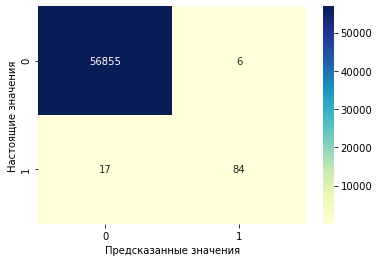

In [23]:
cnf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(pd.DataFrame(cnf_matrix_xgb), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_xgb, target_names=labels))

Text(0.5, 1.0, 'Precision Recall Curve')

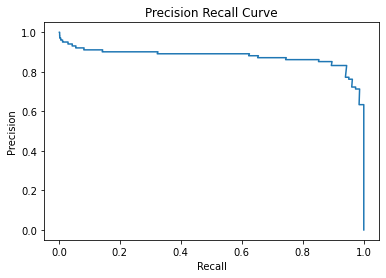

In [24]:
y_pred_prob_xgb = model_xgb.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_xgb)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

### ____________XGBoost + NearMiss

In [120]:
model_xgb_nearmiss = xgb.XGBClassifier(n_estimators = 5000, max_depth = 10, learning_rate = 0.3)
model_xgb_nearmiss.fit(x_train_nearmiss, y_train_nearmiss)
y_pred_xgb_nearmiss = model_xgb_nearmiss.predict(x_test)


                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.31      0.47     56861
Мошеннические транзакции       0.00      0.98      0.00       101

                accuracy                           0.31     56962
               macro avg       0.50      0.64      0.24     56962
            weighted avg       1.00      0.31      0.47     56962



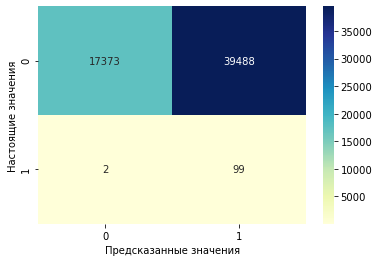

In [121]:
cnf_matrix_xgb_nearmiss = confusion_matrix(y_test, y_pred_xgb_nearmiss)

sns.heatmap(pd.DataFrame(cnf_matrix_xgb_nearmiss), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_xgb_nearmiss, target_names=labels))

### __________XGBoost + SMOTE

In [25]:
model_xgb_smote = xgb.XGBClassifier(n_estimators = 1000, max_depth = 10, learning_rate = 0.3)
model_xgb_smote.fit(x_train_smote, y_train_smote)
y_pred_xgb_smote = model_xgb_smote.predict(x_test)


In [68]:
joblib.dump(model_xgb_smote, "model_xgb_smote.pkl")

['model_xgb_smote.pkl']

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.89      0.85      0.87       101

                accuracy                           1.00     56962
               macro avg       0.94      0.93      0.93     56962
            weighted avg       1.00      1.00      1.00     56962



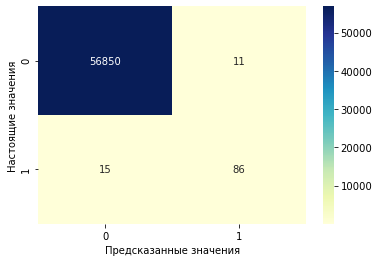

In [26]:
cnf_matrix_xgb_smote = confusion_matrix(y_test, y_pred_xgb_smote)

sns.heatmap(pd.DataFrame(cnf_matrix_xgb_smote), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test, y_pred_xgb_smote, target_names=labels))

Text(0.5, 1.0, 'Precision Recall Curve')

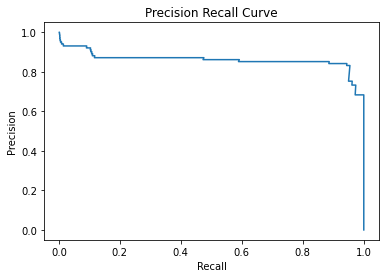

In [27]:
y_pred_prob_xgb_smote = model_xgb_smote.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_xgb_smote)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

XGBoost еще немного улучшил результаты. В целом модель спраилась неплохо - 87% мошеннических транзакций распознаны. При этом лишь небольшое количество обычных транзакций были отнесены к мошенническим (0,02%).  

## Лучшие результаты

Text(761.7272727272725, 0.5, 'Precision')

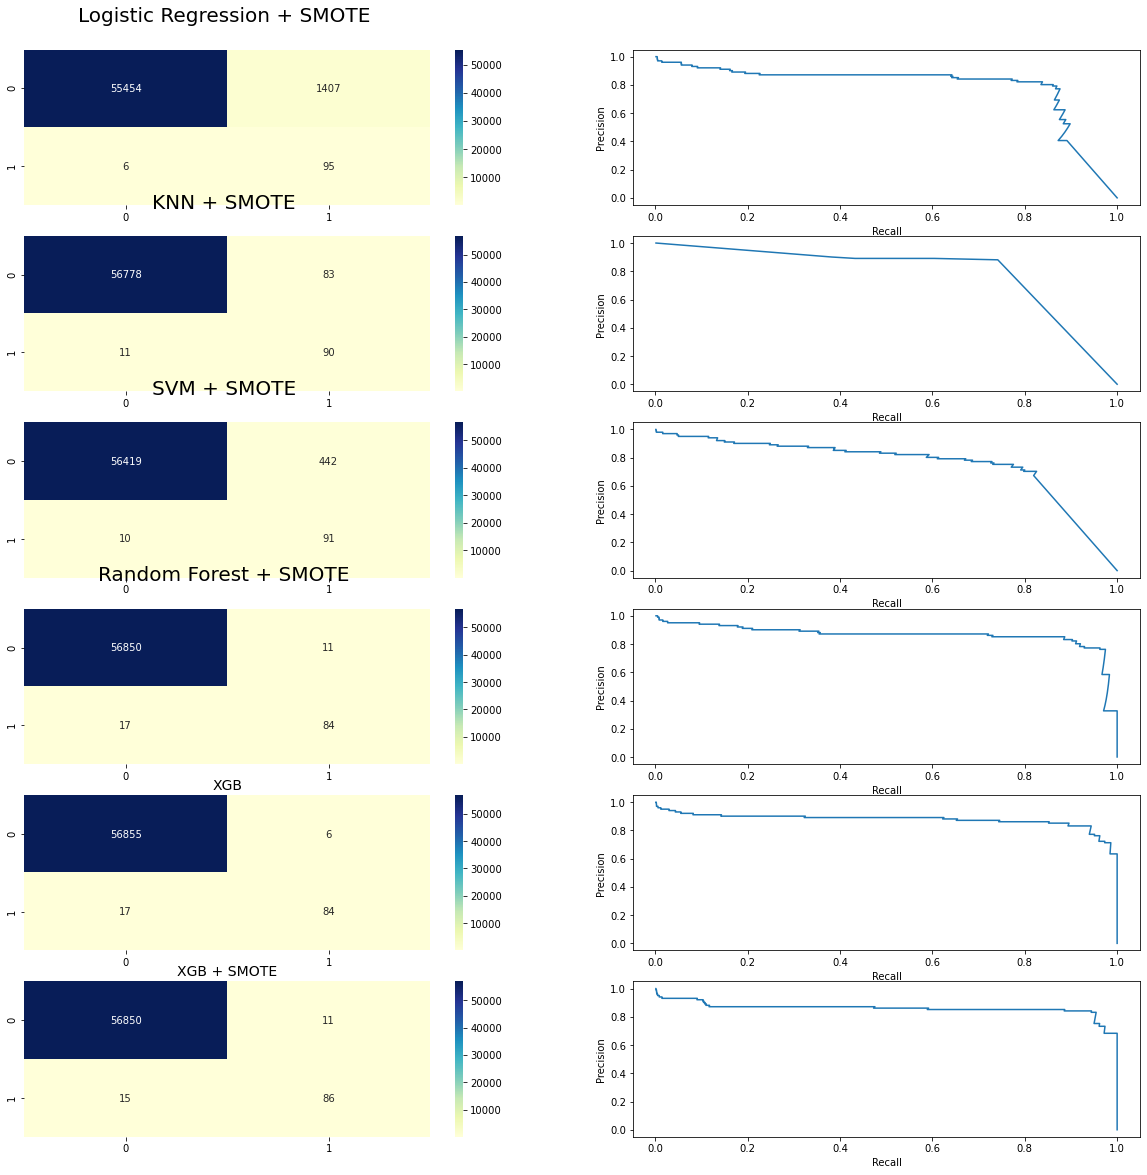

In [42]:
fig, ax = plt.subplots(6, 2,figsize=(20,20))

sns.heatmap(pd.DataFrame(cnf_matrix_logreg_smote), ax=ax[0][0], annot=True, cmap="YlGnBu", fmt='g')
ax[0, 0].set_title("Logistic Regression + SMOTE \n", fontsize=20)
precision_logreg_smote, recall_logreg_smote, thresholds_logreg_smote = precision_recall_curve(y_test, y_pred_prob_logreg_smote)
ax[0,1].plot(precision_logreg_smote, recall_logreg_smote)
ax[0,1].set_xlabel('Recall')   
ax[0,1].set_ylabel('Precision')
# plt.title('Precision Recall Curve')



sns.heatmap(pd.DataFrame(cnf_matrix_knn_smote), ax=ax[1][0], annot=True, cmap="YlGnBu", fmt='g')
ax[1, 0].set_title("KNN + SMOTE \n", fontsize=20)
precision_knn_smote, recall_knn_smote, thresholds_knn_smote = precision_recall_curve(y_test, y_pred_prob_knn_smote)
ax[1,1].plot(precision_knn_smote, recall_knn_smote)
ax[1,1].set_xlabel('Recall')   
ax[1,1].set_ylabel('Precision')


sns.heatmap(pd.DataFrame(cnf_matrix_svm_smote), ax=ax[2][0], annot=True, cmap="YlGnBu", fmt='g')
ax[2, 0].set_title("SVM + SMOTE \n", fontsize=20)
precision_svm_smote, recall_svm_smote, thresholds_svm_smote = precision_recall_curve(y_test, y_pred_prob_svm_smote)
ax[2,1].plot(precision_svm_smote, recall_svm_smote)
ax[2,1].set_xlabel('Recall')   
ax[2,1].set_ylabel('Precision')



sns.heatmap(pd.DataFrame(cnf_matrix_rand_f_smote), ax=ax[3][0], annot=True, cmap="YlGnBu", fmt='g')
ax[3, 0].set_title("Random Forest + SMOTE \n", fontsize=20)
precision_rand_f_smote, recall_rand_f_smote, thresholds_rand_f_smote = precision_recall_curve(y_test, y_pred_prob_rand_f_smote)
ax[3,1].plot(precision_rand_f_smote, recall_rand_f_smote)
ax[3,1].set_xlabel('Recall')   
ax[3,1].set_ylabel('Precision')



sns.heatmap(pd.DataFrame(cnf_matrix_xgb), ax=ax[4][0], annot=True, cmap="YlGnBu", fmt='g')
ax[4, 0].set_title("XGB", fontsize=14)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_pred_prob_xgb)
ax[4,1].plot(precision_xgb, recall_xgb)
ax[4,1].set_xlabel('Recall')   
ax[4,1].set_ylabel('Precision')


sns.heatmap(pd.DataFrame(cnf_matrix_xgb_smote), ax=ax[5][0], annot=True, cmap="YlGnBu", fmt='g')
ax[5, 0].set_title("XGB + SMOTE", fontsize=14)
precision_xgb_smote, recall_xgb_smote, thresholds_xgb_smote = precision_recall_curve(y_test, y_pred_prob_xgb_smote)
ax[5,1].plot(precision_xgb_smote, recall_xgb_smote)
ax[5,1].set_xlabel('Recall')   
ax[5,1].set_ylabel('Precision')


In [48]:
f1_logreg_smote = round(f1_score(y_test, y_pred_logreg_smote), 2)
recall_logreg_smote = round(recall_score(y_test, y_pred_logreg_smote), 2) 
precision_logreg_smote = round(precision_score(y_test, y_pred_logreg_smote), 2) 
accuracy_logreg_smote = round(accuracy_score(y_test, y_pred_logreg_smote), 2) 

f1_knn_smote = round(f1_score(y_test, y_pred_knn_smote), 2)
recall_knn_smote = round(recall_score(y_test, y_pred_knn_smote), 2) 
precision_knn_smote = round(precision_score(y_test, y_pred_knn_smote),2)
accuracy_knn_smote = round(accuracy_score(y_test, y_pred_knn_smote),2) 

f1_svm_smote = round(f1_score(y_test, y_pred_svm_smote), 2)
recall_svm_smote = round(recall_score(y_test, y_pred_svm_smote), 2) 
precision_svm_smote = round(precision_score(y_test, y_pred_svm_smote), 2) 
accuracy_svm_smote = round(accuracy_score(y_test, y_pred_svm_smote),2) 

f1_rand_f_smote = round(f1_score(y_test, y_pred_rand_f_smote), 2)
recall_rand_f_smote = round(recall_score(y_test, y_pred_rand_f_smote), 2) 
precision_rand_f_smote = round(precision_score(y_test, y_pred_rand_f_smote), 2) 
accuracy_rand_f_smote = round(accuracy_score(y_test, y_pred_rand_f_smote),2) 

f1_xgb = round(f1_score(y_test, y_pred_xgb), 2)
recall_xgb = round(recall_score(y_test, y_pred_xgb), 2) 
precision_xgb = round(precision_score(y_test, y_pred_xgb), 2) 
accuracy_xgb = round(accuracy_score(y_test, y_pred_xgb), 2) 

f1_xgb_smote = round(f1_score(y_test, y_pred_xgb_smote), 2)
recall_xgb_smote = round(recall_score(y_test, y_pred_xgb_smote), 2) 
precision_xgb_smote = round(precision_score(y_test, y_pred_xgb_smote), 2) 
accuracy_xgb_smote = round(accuracy_score(y_test, y_pred_xgb_smote),2) 


In [50]:
results = {'Модель': ['Logistic Regression + SMOTE', 'KNN + SMOTE', 'SVM + SMOTE', 'Random Forest + SMOTE', 'XGBoost', 'XGBoost + SMOTE'], 
     'Accuracy': [accuracy_logreg_smote, accuracy_knn_smote, accuracy_svm_smote, accuracy_rand_f_smote, accuracy_xgb, accuracy_xgb_smote],
     'Precision': [precision_logreg_smote, precision_knn_smote, precision_svm_smote, precision_rand_f_smote, precision_xgb, precision_xgb_smote],
     'Recall': [recall_logreg_smote, recall_knn_smote, recall_svm_smote, recall_rand_f_smote, recall_xgb, recall_xgb_smote],
     'f1': [f1_logreg_smote, f1_knn_smote, f1_svm_smote, f1_rand_f_smote, f1_xgb, f1_xgb_smote]
    }
results_df = pd.DataFrame(data=results)
results_df


,Модель,Accuracy,Precision,Recall,f1
0,Logistic Regression + SMOTE,0.98,0.06,0.94,0.12
1,KNN + SMOTE,1.00,0.52,0.89,0.66
2,SVM + SMOTE,0.99,0.17,0.90,0.29
3,Random Forest + SMOTE,1.00,0.88,0.83,0.86
4,XGBoost,1.00,0.93,0.83,0.88
5,XGBoost + SMOTE,1.00,0.89,0.85,0.87


### Выводы

- Баланс классов очень важный фактор при обучении модели. Балансировка классов играет большую роль для улучшения результатов;
- При дисбалансе классов необходимо очень внимательно выбирать метрики качества модели;  
- Балансировка классов с помощью оверсемплинга везде дала ухудшение результатов. Вероятно произошло это из-за слишком небольшого количества сэмплов миноритарного класса;
- Random Forest Classifier и XGBoost дали хорошие результаты, распознав более 80% мошеннических транзакций, не допустив большого количества ошибок по отношению в обычным транзакциям.



### Доработка

In [162]:
data_2 = data

In [93]:
data_2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


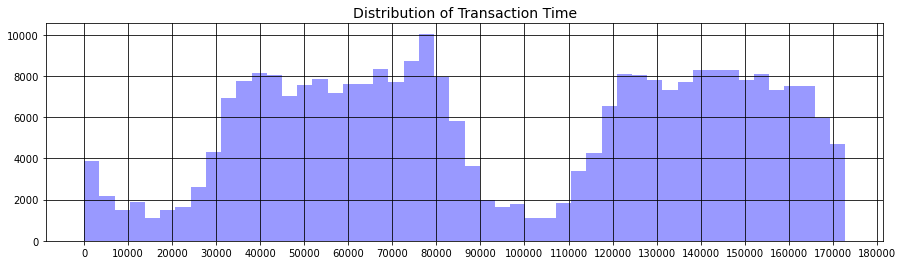

In [164]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(15,4))

time_val = data['Time'].values

sns.distplot(time_val, color='b', kde=False)
plt.title('Distribution of Transaction Time', fontsize=14)
ax.grid(which='major',
        color = 'k')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))

Видим, что распределение кол-ва транзакций в зависимости от времени имеет некоторую цикличность. Предполагаю, что периоды с большим кол-вом транзакций это день, а периоды с небольшим кол-вом тразакций - ночь. Попробуем учесть это в наших данных.

In [ ]:
data_2['timestamp'] = np.nan

In [167]:
# Пометим единицей транзакции сделанные условно в дневной период, и 0 в ночной (в колонке timestamp) 
for i in range(0, len(data_2)):
    if 30000 < data_2.iloc[i]['Time'] < 86000:
        data_2.loc[i,'timestamp'] = 1,
    if data_2.iloc[i]['Time'] > 113000:
        data_2.loc[i,'timestamp'] = 1
    else:
        data_2.loc[i,'timestamp'] = 0      

In [169]:
data_2.to_csv('data_timestamp.csv', header=True)

In [221]:
data_2 = pd.read_csv('data_timestamp.csv')

In [222]:
data_2.drop(['Unnamed: 0'], axis=1, inplace=True)

In [223]:
data_2

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,timestamp
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1.0


In [224]:
data_2['timestamp'].value_counts()

0.0    159848
1.0    124959
Name: timestamp, dtype: int64

In [225]:
data_2.drop(['Time'], axis=1, inplace=True)

### Масштабирование признаков

In [218]:
data_2

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,timestamp
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1.0


In [226]:
data_2.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,timestamp
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,3.923752e-15,5.559442e-16,-8.769520e-15,2.759583e-15,-1.549320e-15,2.005278e-15,-1.695447e-15,-1.933764e-16,-3.136288e-15,1.771777e-15,...,7.961936e-16,5.402018e-16,4.459446e-15,1.446667e-15,1.705578e-15,-3.668456e-16,-1.203990e-16,88.349619,0.001727,0.438750
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,0.496235
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,1.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,1.000000


In [227]:
rs = RobustScaler()
data_2['scaled_amount'] = rs.fit_transform(data_2['Amount'].values.reshape(-1,1))
data_2.drop(['Amount'], axis=1, inplace=True)

for i in range(0, 28):
    data_2['V'+str(i+1)+'_rs'] = rs.fit_transform(data_2['V'+str(i+1)].values.reshape(-1,1))
    


In [228]:
data_2.drop(data_2.columns[0:28], axis=1, inplace=True)
data_2

,Class,timestamp,scaled_amount,V1_rs,V2_rs,V3_rs,V4_rs,V5_rs,V6_rs,V7_rs,...,V19_rs,V20_rs,V21_rs,V22_rs,V23_rs,V24_rs,V25_rs,V26_rs,V27_rs,V28_rs
0,0,0.0,1.783274,-0.616237,-0.098602,1.228905,0.878152,-0.217859,0.631245,0.177406,...,0.437322,0.910463,0.026866,0.253109,-0.320791,0.032681,0.167619,-0.241182,0.816731,-0.246091
1,0,0.0,-0.269825,0.524929,0.143100,-0.006970,0.293974,0.087726,0.164395,-0.105740,...,-0.163363,-0.019150,-0.473332,-0.602719,0.363442,-0.479557,0.225462,0.313475,-0.063781,0.026519
2,0,0.0,4.983721,-0.615587,-1.002407,0.830932,0.251024,-0.344345,1.778007,0.668164,...,-2.475385,1.703959,0.668917,0.714254,2.974603,-0.919589,-0.515430,-0.153111,-0.350218,-0.540962
3,0,0.0,1.418291,-0.440239,-0.178789,0.841250,-0.529808,0.033775,1.303832,0.175637,...,-1.350843,-0.422194,-0.190105,-0.001408,-0.578786,-1.531963,0.944482,-0.298959,0.379163,0.382611
4,0,0.0,0.670579,-0.526089,0.579239,0.713861,0.265632,-0.270695,0.317183,0.491625,...,0.873809,1.366227,0.048266,0.739092,-0.407980,0.126293,-0.333308,0.976221,1.347133,1.553716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0,1.0,-0.296653,-5.321622,7.135767,-5.222589,-1.285699,-4.073679,-1.999082,-4.409307,...,-0.750239,4.461946,0.585633,0.098124,3.314091,-0.693006,2.126512,0.532055,5.820867,6.190862
284803,0,1.0,0.038986,-0.335820,-0.085979,0.967471,-0.451476,0.707747,1.142041,-0.014027,...,-1.692755,0.354148,0.587444,0.856848,0.076436,-1.331299,-0.933155,-0.604145,0.414680,-0.493534
284804,0,1.0,0.641096,0.850377,-0.261532,-1.788463,-0.337932,2.059687,2.832770,-0.299623,...,-0.634786,0.185279,0.630455,0.533612,-0.085005,0.754500,0.373060,-0.062034,0.019227,-0.288058
284805,0,1.0,-0.167680,-0.115629,0.331602,0.272567,0.445763,-0.248270,0.769496,-0.645865,...,3.162108,0.550857,0.710499,0.740745,-0.491472,0.103549,-0.877058,1.054357,0.663921,0.710829


In [229]:
data_2.describe()

,Class,timestamp,scaled_amount,V1_rs,V2_rs,V3_rs,V4_rs,V5_rs,V6_rs,V7_rs,...,V19_rs,V20_rs,V21_rs,V22_rs,V23_rs,V24_rs,V25_rs,V26_rs,V27_rs,V28_rs
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.001727,0.438750,0.927124,-0.008099,-0.046700,-0.093789,0.012467,0.041684,0.234978,-0.035663,...,-0.004081,0.181230,0.071003,-0.006333,0.036166,-0.051600,-0.024846,0.091805,-0.008291,-0.085674
std,0.041527,0.496235,3.495006,0.875976,1.177594,0.790721,0.889375,1.058858,1.141757,1.100116,...,0.889420,2.236107,1.770910,0.677653,2.017718,0.762671,0.780519,0.849087,2.493334,2.515117
min,0.000000,0.000000,-0.307413,-25.234901,-51.902285,-25.295389,-3.557406,-87.216663,-22.184587,-38.770014,...,-7.885579,-157.892131,-83.903734,-10.215599,-144.743845,-3.623671,-15.440333,-4.494188,-139.401862,-117.657402
25%,0.000000,0.000000,-0.229162,-0.419712,-0.473542,-0.558111,-0.520605,-0.488876,-0.423451,-0.528388,...,-0.502633,-0.432879,-0.479648,-0.512775,-0.486782,-0.498118,-0.499713,-0.483936,-0.445883,-0.489209
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.770838,0.580288,0.526458,0.441889,0.479395,0.511124,0.576549,0.471612,...,0.497367,0.567121,0.520352,0.487225,0.513218,0.501882,0.500287,0.516064,0.554117,0.510791
max,1.000000,1.000000,358.683155,1.089805,15.683274,4.799177,10.612681,26.739834,63.054506,107.201520,...,6.105706,114.523532,65.656022,9.801353,72.828591,5.721572,11.234373,6.285011,195.267780,257.822531


In [204]:
data_2.to_csv('data_timestamp_rs.csv', header=True)

### Сэмплинг

In [230]:
# Сначала разделим имеющиеся данные на тренирововчные и тестовые
from sklearn.model_selection import train_test_split
x_new = np.array(data_2.iloc[:, data_2.columns != 'Class'])
y_new = np.array(data_2.iloc[:, data_2.columns == 'Class'])
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_new, y_new, test_size=0.2, random_state=0)

print(f'Обычные транзакции: {sum(y_train_new == 0)}')
print(f'Мошеннические транзакции: {sum(y_train_new == 1)}')



Обычные транзакции: [227454]
Мошеннические транзакции: [391]


In [231]:
# Увеличим кол-во сэмплов миноритарного класса

model_smote = SMOTE(random_state=2)
x_train_new_smote, y_train_new_smote = model_smote.fit_resample(x_train_new, y_train_new.ravel())

print(f'Обычные транзакции: {sum(y_train_new_smote == 0)}')
print(f'Мошеннические транзакции: {sum(y_train_new_smote == 1)}')

Обычные транзакции: 227454
Мошеннические транзакции: 227454


### Обучим модели и сравним новые результаты с полученными ранее

#### Логистическая регрессия

In [207]:
#Несбалансированные тренировочные датасеты 

logreg_new = LogisticRegression()
logreg_new.fit(x_train_new, y_train_new)
y_pred_new = logreg_new.predict(x_test_new)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.88      0.63      0.74       101

                accuracy                           1.00     56962
               macro avg       0.94      0.82      0.87     56962
            weighted avg       1.00      1.00      1.00     56962



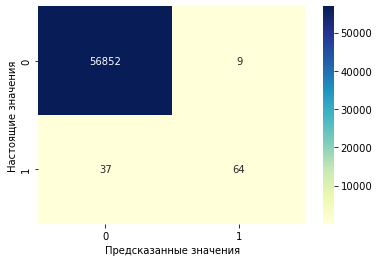

In [208]:
cnf_matrix_new = confusion_matrix(y_test_new, y_pred_new)

sns.heatmap(pd.DataFrame(cnf_matrix_new), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test_new, y_pred_new, target_names=labels))

In [212]:
#logreg+SMOTE 

logreg_smote_new = LogisticRegression()
logreg_smote_new.fit(x_train_new_smote, y_train_new_smote)
y_pred_new_logreg_smote = logreg_smote_new.predict(x_test_new)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.98      0.99     56861
Мошеннические транзакции       0.06      0.94      0.12       101

                accuracy                           0.98     56962
               macro avg       0.53      0.96      0.55     56962
            weighted avg       1.00      0.98      0.99     56962



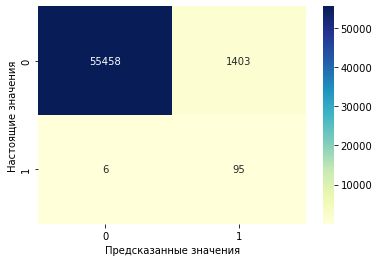

In [213]:
cnf_matrix_logreg_smote_new = confusion_matrix(y_test_new, y_pred_new_logreg_smote)

sns.heatmap(pd.DataFrame(cnf_matrix_logreg_smote_new), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения') 

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test_new, y_pred_new_logreg_smote, target_names=labels))

## SVM

In [235]:
#Несбалансированные тренирововчные датасеты 

model_svm_new = svm.SVC(kernel='poly', degree=2)
model_svm_new.fit(x_train_new, y_train_new)
y_pred_svm_new = model_svm_new.predict(x_test_new)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.94      0.75      0.84       101

                accuracy                           1.00     56962
               macro avg       0.97      0.88      0.92     56962
            weighted avg       1.00      1.00      1.00     56962



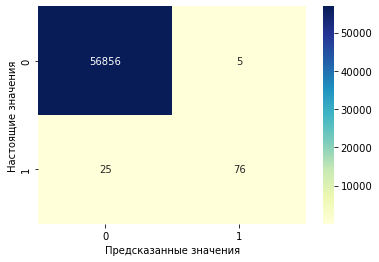

In [236]:
cnf_matrix_svm_new = confusion_matrix(y_test_new, y_pred_svm_new)

sns.heatmap(pd.DataFrame(cnf_matrix_svm_new), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test_new, y_pred_svm_new, target_names=labels))

In [238]:
#SVM + SMOTE

model_svm_smote_new = svm.SVC(kernel='poly', degree=2, probability = True)
model_svm_smote_new.fit(x_train_new_smote, y_train_new_smote)
y_pred_svm_smote_new = model_svm_smote_new.predict(x_test_new)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      0.99      1.00     56861
Мошеннические транзакции       0.17      0.91      0.29       101

                accuracy                           0.99     56962
               macro avg       0.59      0.95      0.64     56962
            weighted avg       1.00      0.99      0.99     56962



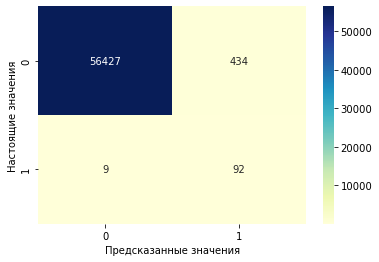

In [239]:
cnf_matrix_svm_smote_new = confusion_matrix(y_test_new, y_pred_svm_smote_new)

sns.heatmap(pd.DataFrame(cnf_matrix_svm_smote_new), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test_new, y_pred_svm_smote_new, target_names=labels))

#### XGBoost

In [233]:
#Несбалансированные тренировочные датасеты 

model_xgb_new = xgb.XGBClassifier(n_estimators = 5000, max_depth = 10, learning_rate = 0.3)
model_xgb_new.fit(x_train_new, y_train_new)
y_pred_xgb_new = model_xgb_new.predict(x_test_new)

                          precision    recall  f1-score   support

      Обычные транзакции       1.00      1.00      1.00     56861
Мошеннические транзакции       0.94      0.83      0.88       101

                accuracy                           1.00     56962
               macro avg       0.97      0.92      0.94     56962
            weighted avg       1.00      1.00      1.00     56962



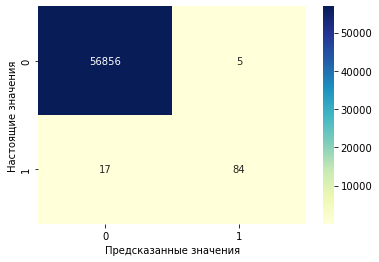

In [234]:
cnf_matrix_xgb_new = confusion_matrix(y_test_new, y_pred_xgb_new)

sns.heatmap(pd.DataFrame(cnf_matrix_xgb_new), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Настоящие значения')
plt.xlabel('Предсказанные значения')

labels = ['Обычные транзакции', 'Мошеннические транзакции']
print(classification_report(y_test_new, y_pred_xgb_new, target_names=labels))